In [1]:
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error,r2_score
from tensorflow.keras.callbacks import TensorBoard

# Random forest regression

In [2]:
df = pd.read_csv(os.getcwd()+"/pre_processing/dataset_traite.csv", sep=',', parse_dates=["DateTime"])

In [4]:
def data_to_supervised(df, col_to_predict="Global_active_power"):
    data = pd.DataFrame(df)
    n_vars = data.shape[1]
    columns = []
    columns.append(data.shift(1))
    columns.append(data.shift(0)[col_to_predict])
    df_labeled = pd.concat(columns, axis=1)
    names = [col + "(t-1)" for col in df.columns]
    names.append(f"{col_to_predict}(t)")
    df_labeled.columns = names
    df_labeled.dropna(inplace=True)
    
    return df_labeled

In [5]:
df_rf = df.set_index('DateTime')
df_rf = df_rf.resample('h').mean()
df_rf['Date'] = pd.to_datetime(df_rf.index.date)
df_rf.head(3)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Date
DateTime,,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,2006-12-16
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,2006-12-16
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,2006-12-16


In [7]:
temperatures = pd.read_csv("pre_processing/temperatures.csv", parse_dates=['Date'], index_col='Date')
temperatures['avg_t'] = (temperatures['max_t'] - temperatures['min_t'])/2
temperatures.head(2)

,min_t,max_t,avg_t
Date,,,
2006-01-02,3.0,7.6,2.30
2006-01-03,3.9,6.8,1.45


In [8]:
df_rf = df_rf.join(temperatures, how="left", on='Date')
df_rf = df_rf.drop(columns=['Date','avg_t'])
df_rf.head(3)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,min_t,max_t
DateTime,,,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,0.3,9.5
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,0.3,9.5
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,0.3,9.5


In [22]:
#colonne unique int
# df_rf["Hour"] = df_rf.index.hour
# df_rf["Day"] = df_rf.index.dayofweek
# df_rf["Month"] = df_rf.index.month

#pour colonnes binaires :
# days=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
# for i in range(7):
#     df_rf[days[i]] = (df_rf.index.dayofweek == i).astype(int)

In [9]:
scaler = MinMaxScaler(feature_range=(-1,1))
df_rf[df_rf.columns] = scaler.fit_transform(df_rf[df_rf.columns])
df_rf.describe()

df_rf["Hour"] = df_rf.index.hour
df_rf["Day"] = df_rf.index.dayofweek
df_rf["Month"] = df_rf.index.month

# df_rf = data_to_supervised(df_rf)
df_rf.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,min_t,max_t,Hour,Day,Month
DateTime,,,,,,,,,,,,
2006-12-16 17:00:00,0.273632,-0.408523,-0.324109,0.262315,-1.0,-0.977267,0.564836,-0.415873,-0.321519,17,5,12
2006-12-16 18:00:00,0.090090,-0.793285,-0.328998,0.082975,-1.0,-0.710696,0.565352,-0.415873,-0.321519,18,5,12
2006-12-16 19:00:00,0.018012,-0.779854,-0.432397,0.004304,-1.0,-0.938263,0.548337,-0.415873,-0.321519,19,5,12
2006-12-16 20:00:00,-0.022901,-0.806027,-0.368025,-0.037781,-1.0,-1.000000,0.557618,-0.415873,-0.321519,20,5,12
2006-12-16 21:00:00,-0.088806,-0.801980,-0.131166,-0.100191,-1.0,-0.982053,0.597834,-0.415873,-0.321519,21,5,12


In [12]:
# dataset de validation qu'on garde dans l'ordre chronologique, pour tester une fois le modele entrainé avec le reste des données shuffled
df_val = df_rf.loc[df_rf.index > "2010-11-15"]
df_val.shape[0]

df_rf = df_rf.loc[df_rf.index <= "2010-11-15"]

In [10]:
def create_train_rf(df_rf, y_col="Global_active_power", train_size = 0.8, shuffle=True):
    df_rf = data_to_supervised(df_rf, y_col)
    y_col = y_col + '(t)'
    X = df_rf.copy().drop(columns=[y_col])
    y = df_rf[y_col]

    train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=train_size, shuffle=shuffle, random_state = 1)

    rf_reg = RandomForestRegressor(n_estimators = 500, random_state = 1)
    rf_reg.fit(train_X, train_y)

    ypred = rf_reg.predict(test_X)
    r2 = r2_score(test_y, ypred)
    r_adjusted = 1 - ( 1-r2 ) * ( len(test_y) - 1 ) / ( len(test_y) - test_X.shape[1] - 1 )
    mse = mean_squared_error(test_y, ypred)
    rmse = np.sqrt(mse)

    scores = {}
    scores['r2'] = r2
    scores['r_adjusted'] = r_adjusted
    scores['mse'] = mse
    scores['rmse'] = rmse

    return rf_reg, scores

In [11]:
#test of function above
model, scores = create_train_rf(df_rf, 'Global_active_power', train_size = 0.8, shuffle=True)
print(f"R-squared: {scores['r2']}")
print(f"Adjusted R-squared: {scores['r_adjusted']}")
print(f"Test MSE: {scores['mse']}")
print(f"Test RMSE: {scores['rmse']}")

R-squared: 0.6379027911164337
Adjusted R-squared: 0.6372733305186351
Test MSE: 0.02759099333566183
Test RMSE: 0.16610536817231955


In [13]:
def create_models_all_var(df_rf, train_size=0.8, shuffle=True, verbose=False):
    non_predictable_vars = ["min_t", "max_t", "avg_t", "Hour", "Day", "Month"]
    models = {}
    models_scores = {}
    for col in df_rf.columns:
        if(col not in non_predictable_vars):
            if(verbose):
                print(f"Training a model on predicting the {col} variable")
            model, scores = create_train_rf(df_rf, col, train_size, shuffle)
            models[col] = model
            models_scores[col] = scores

    return models, models_scores

In [14]:
models, models_scores = create_models_all_var(df_rf, train_size=0.8, shuffle=True, verbose=True)

Training a model on predicting the Global_active_power variable
Training a model on predicting the Global_reactive_power variable
Training a model on predicting the Voltage variable
Training a model on predicting the Global_intensity variable
Training a model on predicting the Sub_metering_1 variable
Training a model on predicting the Sub_metering_2 variable
Training a model on predicting the Sub_metering_3 variable


In [15]:
#test of function above
for col in models_scores.keys():
    print(f"\nScores for the model trained to predict {col}:")
    print(f"R-squared: {models_scores[col]['r2']}")
    print(f"Adjusted R-squared: {models_scores[col]['r_adjusted']}")
    print(f"Test MSE: {models_scores[col]['mse']}")
    print(f"Test RMSE: {models_scores[col]['rmse']}")


Scores for the model trained to predict Global_active_power:
R-squared: 0.627896439374717
Adjusted R-squared: 0.627239109369196
Test MSE: 0.02883853494488349
Test RMSE: 0.16981912420243925

Scores for the model trained to predict Global_reactive_power:
R-squared: 0.36841721409561723
Adjusted R-squared: 0.36730150771686665
Test MSE: 0.019610152212044686
Test RMSE: 0.14003625320624902

Scores for the model trained to predict Voltage:
R-squared: 0.7761458373969121
Adjusted R-squared: 0.7757503935648442
Test MSE: 0.01198568727736919
Test RMSE: 0.109479163667655

Scores for the model trained to predict Global_intensity:
R-squared: 0.6235398636045979
Adjusted R-squared: 0.6228748376018385
Test MSE: 0.02728029919588498
Test RMSE: 0.16516748831378705

Scores for the model trained to predict Sub_metering_1:
R-squared: 0.2707463844010397
Adjusted R-squared: 0.2694581401220485
Test MSE: 0.01569465595317812
Test RMSE: 0.12527831397803102

Scores for the model trained to predict Sub_metering_2:
R-

In [17]:
def predict_all_variables(models, x_row, timesteps_forward=1):
    date_initiale = x_row.iloc[0].index
    
    rows = x_row.copy()
    names = [col + "(t-1)" for col in rows.columns]
    rows.columns = names
    for i in range(timesteps_forward):
        prediction = []
        for model_name in models.keys():
            last_line = pd.DataFrame(rows.iloc[rows.shape[0]-1]).transpose()
            prediction.append(models[model_name].predict(last_line)[0])
        # print(prediction)
        prediction.append(rows["min_t(t-1)"].values[-1])
        prediction.append(rows["max_t(t-1)"].values[-1])
        prediction.append(rows["Hour(t-1)"].values[-1] + 1)
        prediction.append(rows["Day(t-1)"].values[-1])
        prediction.append(rows["Month(t-1)"].values[-1])

        prediction = pd.Series(prediction, index = names)
        rows = rows.append(prediction, ignore_index=True)
    # prediction_df = pd.DataFrame(prediction)
    # rows = rows.append(prediction_df)
    return rows

In [36]:
row = pd.DataFrame(df_val.iloc[23]).transpose()
row

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,min_t,max_t,Hour,Day,Month
2010-11-16,-0.937917,-0.816014,0.297554,-0.938068,-1.0,-1.0,-1.0,0.015873,-0.240506,0.0,1.0,11.0


In [37]:
res = predict_all_variables(models, row, 23)
res

,Global_active_power(t-1),Global_reactive_power(t-1),Voltage(t-1),Global_intensity(t-1),Sub_metering_1(t-1),Sub_metering_2(t-1),Sub_metering_3(t-1),min_t(t-1),max_t(t-1),Hour(t-1),Day(t-1),Month(t-1)
0,-0.937917,-0.816014,0.297554,-0.938068,-1.000000,-1.000000,-1.000000,0.015873,-0.240506,0.0,1.0,11.0
1,-0.915807,-0.774170,0.263168,-0.916606,-1.000000,-0.983921,-0.925058,0.015873,-0.240506,1.0,1.0,11.0
2,-0.909936,-0.771617,0.322386,-0.909047,-1.000000,-0.990926,-0.843397,0.015873,-0.240506,2.0,1.0,11.0
3,-0.899466,-0.755824,0.294238,-0.902864,-1.000000,-0.983696,-0.782698,0.015873,-0.240506,3.0,1.0,11.0
4,-0.896627,-0.771323,0.277674,-0.896131,-1.000000,-0.988202,-0.612520,0.015873,-0.240506,4.0,1.0,11.0
5,-0.858766,-0.772417,0.240641,-0.859231,-1.000000,-0.986777,-0.561980,0.015873,-0.240506,5.0,1.0,11.0
6,-0.752198,-0.777782,0.224158,-0.767446,-1.000000,-0.987773,-0.535932,0.015873,-0.240506,6.0,1.0,11.0
7,-0.302493,-0.759218,0.049120,-0.337249,-0.979803,-0.986693,0.676875,0.015873,-0.240506,7.0,1.0,11.0
8,-0.463418,-0.762852,0.054934,-0.486468,-0.639991,-0.973565,0.704575,0.015873,-0.240506,8.0,1.0,11.0
9,-0.540265,-0.796675,0.064593,-0.549220,-0.671938,-0.939967,0.664427,0.015873,-0.240506,9.0,1.0,11.0


In [38]:
inv_y = df_val["Global_active_power"]
inv_yhat = res["Global_active_power(t-1)"]

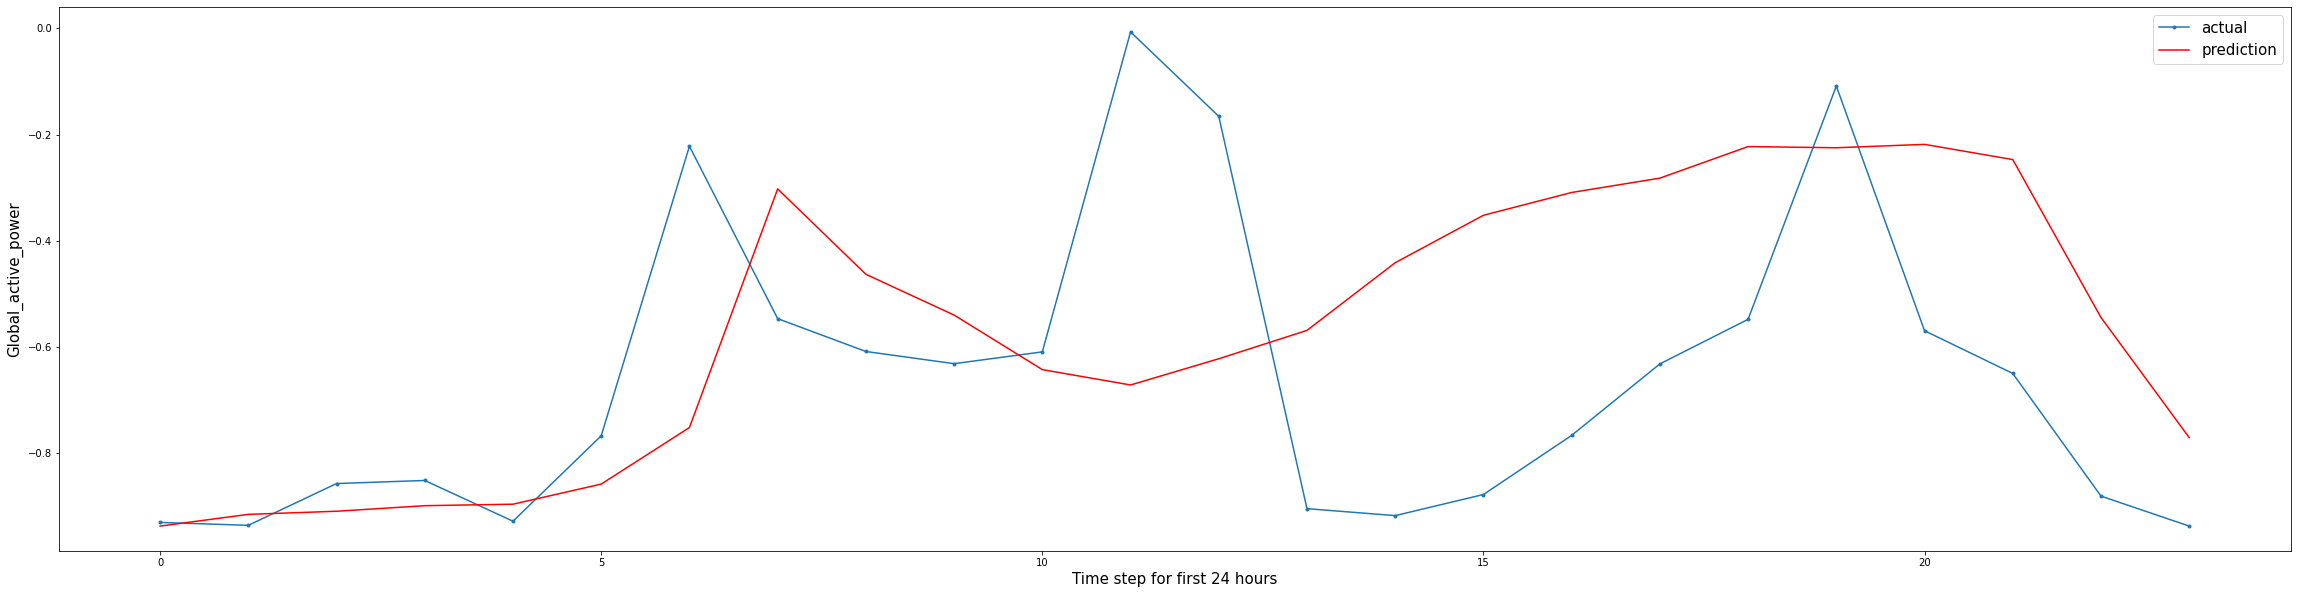

In [39]:
nbr_steps = 24
aa=[x for x in range(nbr_steps)]
plt.figure(figsize=(40,10))
plt.plot(aa, inv_y[:nbr_steps], marker='.', label="actual")
plt.plot(aa, inv_yhat[:nbr_steps], 'r', label="prediction")
plt.ylabel(df.columns[1], size=15)
plt.xlabel(f'Time step for first {nbr_steps} hours', size=15)
plt.legend(fontsize=15)
plt.show()

In [ ]:
# X = df_rf.copy().drop(columns=['Global_active_power(t)'])
# y = df_rf["Global_active_power(t)"]

In [ ]:
# dataset de validation qu'on garde dans l'ordre chronologique, pour tester une fois le modele entrainé avec le reste des données shuffled
# val_X = X.loc[X.index > "2010-11-15"]
# val_y = y.loc[y.index > "2010-11-15"]
# val_X.shape[0]

# X = X.loc[X.index <= "2010-11-15"]
# y = y.loc[y.index <= "2010-11-15"]

In [ ]:
# train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, shuffle=True)

In [ ]:
# rf_reg = RandomForestRegressor(n_estimators = 500, random_state = 1)
# rf_reg.fit(train_X, train_y)

In [ ]:
# ypred = rf_reg.predict(test_X)

# r2 = r2_score(test_y, ypred)
# print("R-squared:", r2)
# r_adjusted = 1 - ( 1-r2 ) * ( len(test_y) - 1 ) / ( len(test_y) - test_X.shape[1] - 1 )
# print("Adjusted R-squared:", r_adjusted)

# mse = mean_squared_error(test_y, ypred)
# print(f'Test MSE: {mse}')
# rmse = np.sqrt(mse)
# print(f'Test RMSE: {rmse}')

In [ ]:
# size = df_rf.shape[1]-1
# test_X["ypred"] = ypred
# test_X
# ypred = ypred.reshape(-1,1)
# ypred = scaler.inverse_transform(test_X)["ypred"]
# # test_y = scaler.inverse_transform(test_y)

# inv_yhat = np.concatenate((ypred, test_X[:, 1-size:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]

# test_y = test_y.reshape((len(test_y), 1))
# inv_y = np.concatenate((test_y, test_X[:, 1-size:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]

# descaler = MinMaxScaler()
# descaler.min_,descaler.scale_=scaler.min_[0],scaler.scale_[0]
# ypred = descaler.inverse_transform(ypred)

In [ ]:
val_ypred = rf_reg.predict(val_X)

In [ ]:
nbr_steps = 200
aa=[x for x in range(nbr_steps)]
plt.figure(figsize=(40,10))
plt.plot(aa, val_y[:nbr_steps], marker='.', label="actual")
plt.plot(aa, val_ypred[:nbr_steps], 'r', label="prediction")
plt.ylabel(df.columns[1], size=15)
plt.xlabel('Time step for first 500 hours', size=15)
plt.legend(fontsize=15)
plt.show()

In [ ]:
values = df_rf.values

trainsize = 0.8
n_rows = round(len(values)*trainsize)
print(f"Taille du trainset : {n_rows}")

train = values[:n_rows, :]
test = values[n_rows:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D format as expected by LSTMs [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

model = Sequential()
#recurrent_activation ='selu' # 1er place
#recurrent_activation ='softsign' # 2e place

model.add(LSTM(5*24, input_shape=(train_X.shape[1], train_X.shape[2]),recurrent_activation ='sigmoid',activation='tanh',return_sequences=True))
model.add(LSTM(5*24,recurrent_activation ='sigmoid',activation='tanh',return_sequences=False))
#model.add(LSTM(2*24,recurrent_activation ='sigmoid',activation='tanh'))
#model.add(Dropout(0.2))
model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam')

model.compile(loss='mean_absolute_error', optimizer='adam')
#model.compile(optimizer=tensorflow.keras.optimizers.SGD(learning_rate=0.001),
             # loss=tensorflow.keras.losses.MeanSquaredError(),
             # metrics=['mse'])
model.summary()

In [ ]:
# fit network
history = model.fit(train_X, train_y, epochs=4, batch_size=100, validation_data=(test_X, test_y), verbose=1, shuffle=False)

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
size = df_rf.shape[1]-1
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], size))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [ ]:
test_y

In [ ]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

import sklearn
r2 = sklearn.metrics.r2_score(inv_y, inv_yhat)
print(r2)
r_adjusted = 1 - ( 1-r2 ) * ( len(test_y) - 1 ) / ( len(test_y) - test_X.shape[1] - 1 )
print(r_adjusted)

In [ ]:
nbr_steps = 50
aa=[x for x in range(nbr_steps)]
plt.figure(figsize=(40,10))
plt.plot(aa, inv_y[:nbr_steps], marker='.', label="actual")
plt.plot(aa, inv_yhat[:nbr_steps], 'r', label="prediction")
plt.ylabel(df.columns[1], size=15)
plt.xlabel('Time step for first 500 hours', size=15)
plt.legend(fontsize=15)
plt.show()